# AP(P)3RO PROJECT #

### Projet de deneigement intelligent de Montréal, Canada ###

#### M. Le Gras, A. Naullet, A. Calixte, P. Beaunieux ####

In [4]:
import multiprocessing as mp

import numpy as np
import osmnx as ox

## Partie 1: Cartographie de la ville par le drone ##

In [20]:
place = "Montreal, Canada" # /!\ Replace with Montreal
G = ox.graph_from_place(place, network_type="walk")
#Gp = ox.project_graph(G)

### 1.1: Importation des plans de la ville ###

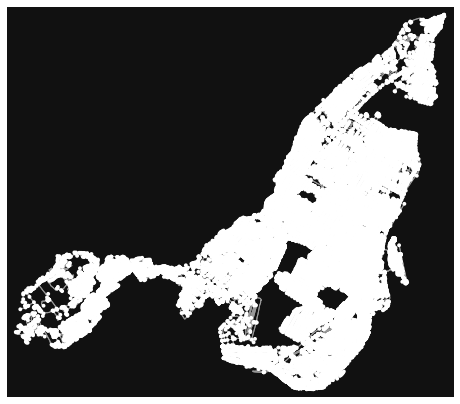

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [21]:
ox.plot_graph(G)

In [22]:
#node1 =list(G.nodes(data=True))[2][0]
#node2 =list(G.nodes(data=True))[42][0]
#print(list(G.nodes(data=True))[2:4])
#print(node1, node2)
node_list = list(G.edges(data=True))
print(len(node_list))

172844


In [31]:
### Construction d'une liste de noeud qui a notre format
graph_city = []
for node in node_list:
    n1 = node[0]
    n2 = node[1]
    dist = node[2]["length"]
    graph_city.append((n1,n2,dist))
### On ne peut pas utiliser l'id des noeuds pour utiliser nos algos.
### On doit construire une table de correspondance entre l'id des noeuds et des numéros croissants de noeuds

CORRESPONDENCE_TABLE = {}
CORRESPONDENCE_TABLE_PRIME = {}

def get_true_node(soft_id):
    if soft_id in CORRESPONDENCE_TABLE_PRIME:
        return CORRESPONDENCE_TABLE_PRIME[soft_id]
    return -1

def to_soft_id_graph(graph_city):
    graph_city_soft_id = []
    soft_id = 1
    
    len_g = len(graph_city)
    index = 1
    
    old_percentage = -1
    for (node1,node2,dist) in graph_city:
        #percentage = (index*100)//len_g
        #print("to soft_id: ",percentage, "%")
        #old_percentage = percentage
        if node1 not in  CORRESPONDENCE_TABLE:
            CORRESPONDENCE_TABLE[node1] = soft_id
            CORRESPONDENCE_TABLE_PRIME[soft_id] = node1
            soft_id += 1
            
        if node2 not in  CORRESPONDENCE_TABLE:
            CORRESPONDENCE_TABLE[node2] = soft_id
            CORRESPONDENCE_TABLE_PRIME[soft_id] = node2
            
            soft_id += 1
        s_id1 = CORRESPONDENCE_TABLE[node1]
        s_id2 = CORRESPONDENCE_TABLE[node2]
        graph_city_soft_id.append((s_id1,s_id2, dist))
    return graph_city_soft_id

def to_real_id_graph(graph_city_soft_id):
    graph_city = []
    soft_id = 1
    for (node1,node2,dist) in graph_city_soft_id:
        n_id1 = get_true_node(node1)
        n_id2 = get_true_node(node2)
    
        graph_city.append((n_id1,n_id2, dist))
    return graph_city

def to_real_id_path(path_soft_id):
    path = []
    soft_id = 1
    for (node1,node2) in path_soft_id:
        n_id1 = get_true_node(node1)
        n_id2 = get_true_node(node2)
    
        path.append(n_id1)
    return path

graph_city_soft_id = to_soft_id_graph(graph_city)
graph_city2 = to_real_id_graph(graph_city_soft_id)
print("DONE")
### On verifie que la conversion des graphes est OK
print("Conversion, re-conversion des graphs: ", ("Erreur","OK")[graph_city == graph_city2])

DONE
Conversion, re-conversion des graphs:  OK


In [72]:
#from caen_path import *
import scripts.eulerian_transform as eulerian
import importlib
importlib.reload(eulerian)

<module 'scripts.eulerian_transform' from '/home/fey/EPITA/ERO/APERRO/scripts/eulerian_transform.py'>

In [ ]:
path = eulerian.transform_and_find_eulerian_path(graph_city_soft_id)

[*] fixing the Graph
[+] Graph fixed
[*] Graph to dict
[*] Starting Fleury
Calcul du chemin Eulerien: 0.0
Calcul du chemin Eulerien: 0.01
Calcul du chemin Eulerien: 0.02


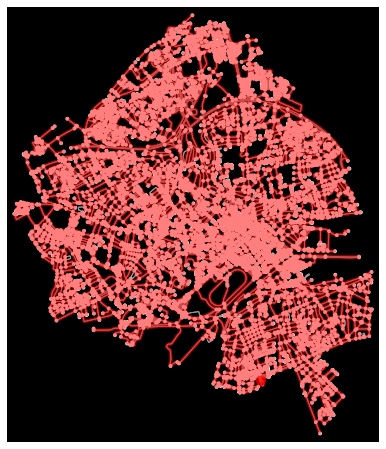

In [20]:
path_real_id = to_real_id_path(caen_path_drone)
#print(path_real_id)
fig, ax = ox.plot_graph_route(G, path_real_id, route_linewidth=3, bgcolor='black')

### 1.2 Calcul du parcours le plus efficace pour le drone ###

In [ ]:
#ICI on fait l'algo

In [ ]:
# ICI ON AFFICHE
#fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k') --> afficher le parcours avec une liste noeud

### 1.3 Recuperation des données du drones (simulation d'eneigement) ###